## Load Python Modules

In [1]:
import numpy as np 
import pandas as pd 
from skimage import filters
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.mixture import GaussianMixture
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
from image import *
from CNN import *
import util
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py:17: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.22.2)
  from scipy.sparse import issparse


ModuleNotFoundError: No module named 'transformers'

## Show NVIDIA GPU

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-6b9114a0-8f28-235b-1a5f-966ba581ef5a)


## Setup Utility

In [3]:
util.setup_logger()

NameError: name 'util' is not defined

# Load and Process Dataset

## Load Dataset

In [4]:
folder_path = os.path.join(os.getenv("HOME"), "scratch")
dataset = ImageDataset(os.path.join(folder_path, "train.csv"), use_augmentation=False, model="ViT")

## Check Dataset

In [5]:
dataset.check()

There are 0 missing values
39975 images with label 0, and 39975 with label 1.
All filenames end with .jpg


## (Optional) Show image for verification

Label: 0, shape: torch.Size([3, 768, 512])


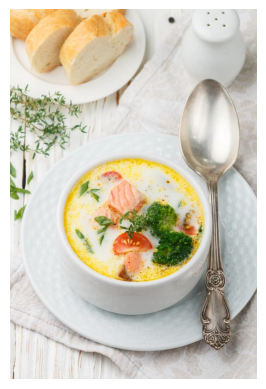

Label: 1, shape: torch.Size([3, 512, 768])


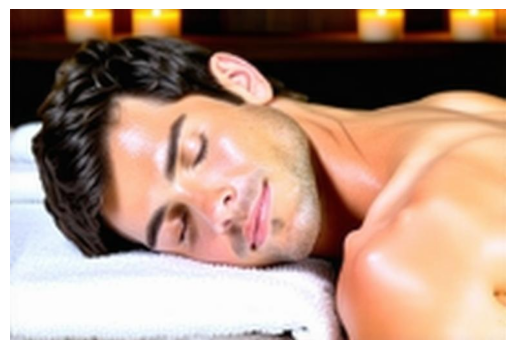

In [6]:
dataset.show_image()

## (Optional) Show normalized images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0, shape: torch.Size([3, 100, 100])


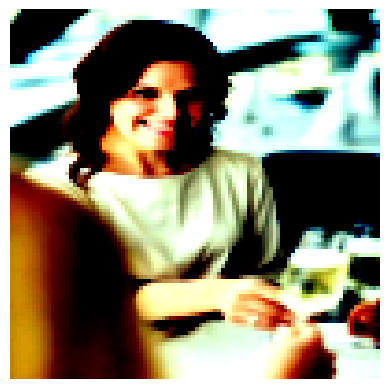

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1, shape: torch.Size([3, 100, 100])


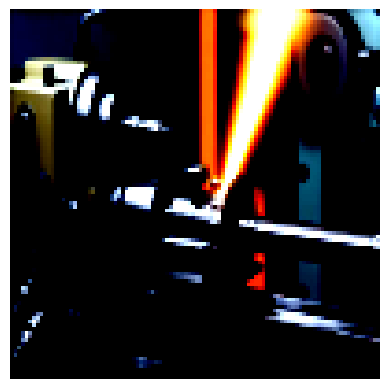

In [7]:
dataset.show_image(transform=True)

## Create Torch Data Loaders

In [8]:
loader = dataset.get_loader(shuffle=False, batch_size=64)

## Check CUDA Availability

In [9]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Flatten Image for PCA

In [10]:
all_images = []
all_labels = []

for batch_idx, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)

    edge_detected_images = []

    for i in range(3):  # Loop through R, G, B channels
        channel = images[:, i, :, :]  # (B, H, W)
        sobel_edges = []
        for img in channel.cpu().numpy(): 
            edge = filters.sobel(img)  # 2D Sobel edge detection
            sobel_edges.append(edge)
        sobel_tensor = torch.tensor(np.stack(sobel_edges)).to(device)  # (B, H, W)
        edge_detected_images.append(sobel_tensor)

    edge_detected_images = torch.stack(edge_detected_images, dim=1)  # (B, 3, H, W)
    
    batch_flat = edge_detected_images.view(edge_detected_images.size(0), -1)
    batch_flat_cpu = batch_flat.cpu().numpy()

    all_images.append(batch_flat_cpu)
    all_labels.append(labels.cpu().numpy())

numpy_images = np.vstack(all_images)
numpy_labels = np.concatenate(all_labels)


# Apply PCA

In [11]:
scaler = StandardScaler()
scaled_images = scaler.fit_transform(numpy_images)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(scaled_images)

# Perform GMM

In [12]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_pca)
glabels = gmm.predict(X_pca)

n_clusters = len(set(glabels))
ari = adjusted_rand_score(numpy_labels, glabels)
nmi = normalized_mutual_info_score(numpy_labels, glabels)
sil = silhouette_score(X_pca, glabels)

print(f"Clusters found: {n_clusters}")
print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")
print(f"Silhouette Score: {sil:.4f}")

Clusters found: 2
ARI: 0.2953
NMI: 0.2393
Silhouette Score: 0.0882


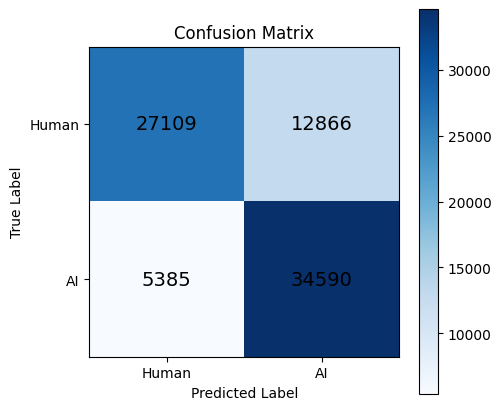

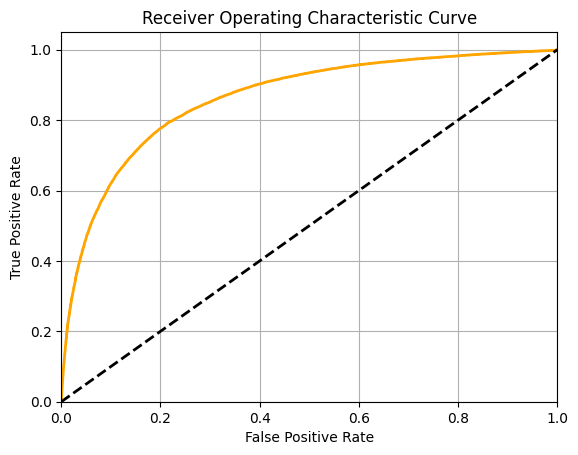

Test Accuracy: 0.7717
F1 Score: 0.7913
F2 Score: 0.8341
AUC: 0.8618


In [13]:
gmm_probs = gmm.predict_proba(X_pca)

y_numpypred = np.argmax(gmm_probs, axis=1)

cm = confusion_matrix(numpy_labels, y_numpypred)

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks([0, 1], ["Human", "AI"])
plt.yticks([0, 1], ["Human", "AI"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)
plt.show()

TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

f2 = 5 * (precision * recall) / ((4 * precision) + recall) if ((4 * precision) + recall) > 0 else 0

fpr, tpr, _ = roc_curve(numpy_labels, gmm_probs[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f"ROC Curve")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.grid(True)
plt.show()

auc = roc_auc_score(numpy_labels, gmm_probs[:, 1])

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")


/tmp/ipykernel_67916/2450053337.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, fill=False, edgecolor='k', linewidth=1.5, **kwargs))


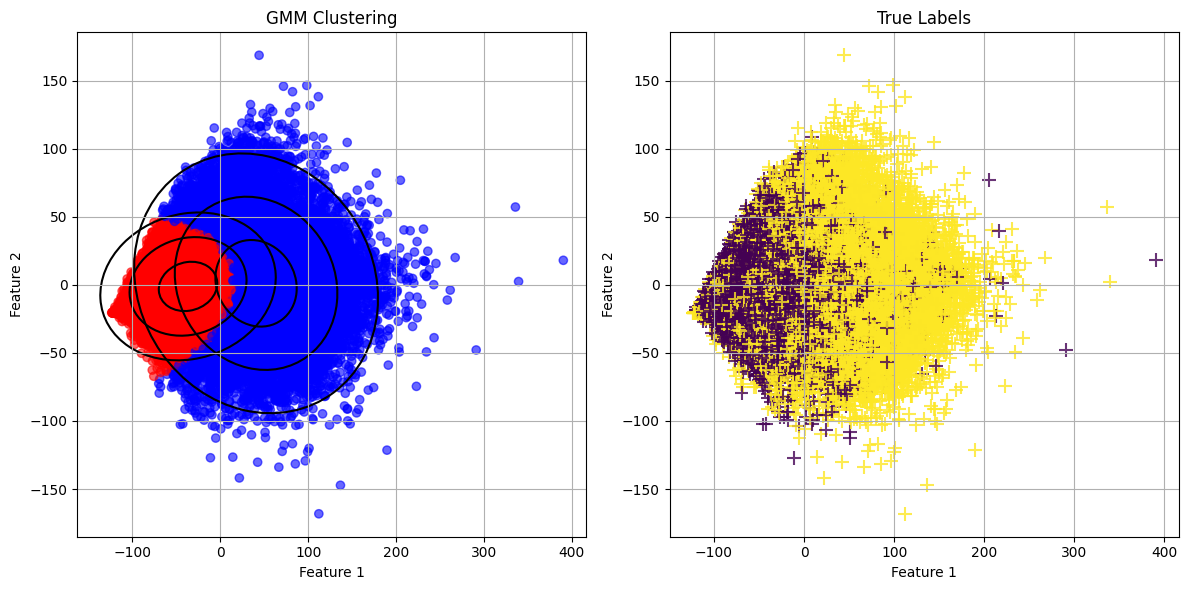

In [14]:
X_2d = PCA(n_components=2).fit_transform(X_pca)

gmm_2d = GaussianMixture(n_components=2, random_state=42)
gmm_2d.fit(X_2d)
labels_2d = gmm_2d.predict(X_2d)

custom_colors = np.array(['red', 'blue'])
colors = custom_colors[labels_2d]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, marker='o', alpha=0.6)

def draw_ellipse(position, covariance, ax, **kwargs):
    U, s, _ = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, fill=False, edgecolor='k', linewidth=1.5, **kwargs))

for mean, cov in zip(gmm_2d.means_, gmm_2d.covariances_):
    draw_ellipse(mean, cov, axes[0])

axes[0].set_title("GMM Clustering")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].grid(True)

axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=numpy_labels, cmap='viridis', marker='+', s=100, alpha=0.8)
axes[1].set_title("True Labels")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()
